# Kernel Functions Profiling

This notebook is there to show how to do some simple function profiling using LISA.

We'll be using the Ftrace function profiler (See "Function profiling" in https://lwn.net/Articles/370423/) for that, and will present the relevant Python APIs from Devlib & LISA that make it easier to use.

In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2019-02-26 16:55:21,469 INFO    : root         : Using LISA logging configuration:
2019-02-26 16:55:21,470 INFO    : root         :   /data/work/lisa/logging.conf


In [2]:
import os
from lisa.target import Target, TargetConf

2019-02-26 16:55:21,487 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2019-02-26 16:55:21,510 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


## Target configuration

The only target requirement here is to have enough Ftrace goodies enabled (look at the requirements for **CONFIG_FUNCTION_PROFILER**)

In [3]:
target = Target(
    kind='linux',
    name='myhikey960',
    host='192.168.0.1',
    username='root',
    password='root',
)

2019-02-26 16:55:22,134 INFO    : lisa.target.Target : Creating result directory: /data/work/lisa/results/Target-myhikey960-20190226_165522.134327
2019-02-26 16:55:22,137 INFO    : lisa.target.Target : linux myhikey960 target connection settings:
2019-02-26 16:55:22,138 INFO    : lisa.target.Target :       host : 192.168.0.1
2019-02-26 16:55:22,140 INFO    : lisa.target.Target :   password : root
2019-02-26 16:55:22,141 INFO    : lisa.target.Target :       port : 22
2019-02-26 16:55:22,142 INFO    : lisa.target.Target :   username : root
2019-02-26 16:55:22,160 INFO    : lisa.target.Target : Devlib modules to load: bl, cgroups, cpufreq, cpuidle, devfreq, fastboot, gem5stats, gpufreq, hotplug, hwmon, mbed-fan, odroidxu3-fan, sched, thermal
2019-02-26 16:55:26,735 WARNING : LinuxTarget  : Module devfreq is not supported by the target
2019-02-26 16:55:26,738 WARNING : LinuxTarget  : Module fastboot is not supported by the target
2019-02-26 16:55:26,739 WARNING : LinuxTarget  : Module gem5

## Experiment setup

We can run whatever we want here, let's just build a simple ((1 20% task) x NR_CPUS) workload

In [1]:
from lisa.wlgen.rta import RTA, RTAPhase, PeriodicWload

In [ ]:
rtapp_profile = {
    f'task{cpu}': RTAPhase(
        prop_wload=PeriodicWload(
            duty_cycle_pct=20,
            period=16e-3,
            duration=1,
        )
    )
    for cpu in range(target.number_of_cpus)
}

In [6]:
wload = RTA.by_profile(target, rtapp_profile, name='profiling_wload')

2019-02-26 16:55:41,167 INFO    : lisa.target.Target : Creating result directory: /data/work/lisa/results/Target-myhikey960-20190226_165522.134327/RTA-profiling_wload-20190226_165541.167219
2019-02-26 16:55:47,120 INFO    : lisa.wlgen.rta.RTA : CPU0 calibration...
2019-02-26 16:55:47,451 INFO    : lisa.wlgen.rta.RTA : Calibration value: CPU0
2019-02-26 16:55:47,453 INFO    : lisa.wlgen.rta.RTA : Default policy: SCHED_OTHER
2019-02-26 16:55:47,454 INFO    : lisa.wlgen.rta.RTA : ------------------------
2019-02-26 16:55:47,456 INFO    : lisa.wlgen.rta.RTA : task [task1], sched: using default policy
2019-02-26 16:55:47,457 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2019-02-26 16:55:47,459 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2019-02-26 16:55:47,461 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2019-02-26 16:55:47,462 INFO    : lisa.wlgen.rta.Phase :  | batch 0.001000 [s]
2019-02-26 16:55:47,707 INFO    : lisa.wlgen.rta.RTA : Execution start: /root/devlib-targ

Now, let's define the functions we want to do some profiling on. Do keep in mind all functions might not be profilable - that can happen if they are inline.

In [7]:
functions = [
    "scheduler_tick",
    "run_rebalance_domains"
]

We're using an FtraceCollector so might as well record some basic events to get a meaningful trace

In [8]:
events = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new"
]

## Running the experiment

In [9]:
from lisa.trace import FtraceCollector

In [ ]:
ftrace_coll = FtraceCollector(target, events=events, functions=functions, buffer_size=10240)

with wload, ftrace_coll:
    wload.run()


In [11]:
!tree {wload.res_dir}

/data/work/lisa/results/Target-myhikey960-20190226_165522.134327/RTA-profiling_wload-20190226_165541.167219
├── output.log
├── profiling_wload.json
├── rt-app-task0-0.log
├── rt-app-task0-4.log
├── rt-app-task0-5.log
├── rt-app-task1-0.log
├── rt-app-task1-3.log
├── rt-app-task1-6.log
├── rt-app-task1-7.log
├── rt-app-task2-0.log
├── rt-app-task2-2.log
├── rt-app-task2-6.log
├── rt-app-task3-3.log
├── rt-app-task3-5.log
├── rt-app-task3-6.log
├── rt-app-task3-7.log
├── rt-app-task4-1.log
├── rt-app-task4-4.log
├── rt-app-task4-7.log
├── rt-app-task5-1.log
├── rt-app-task5-2.log
├── rt-app-task5-5.log
├── rt-app-task6-0.log
├── rt-app-task6-1.log
├── rt-app-task6-4.log
├── rt-app-task7-0.log
├── rt-app-task7-1.log
├── rt-app-task7-3.log
├── rt-app-task7-6.log
├── stats.json
└── trace.dat

0 directories, 31 files


## Using function grapher events


The kernel function grapher emits ``funcgraph_entry`` and ``funcgraph_exit`` events that can be used by LISA to compute profiling statistics and compare them.

In [2]:
# Get a lisa.stats.Stats instance loaded with all the profiling information
stat_funcs = {'mean': None, 'count': None, 'std': None}
# metric is either "self_time" for the time spent in the function or "cum_time" for the cumulative time
# spent in the function and in all its children as well
stats = trace.analysis.functions.profile_stats(metric='self_time', functions=functions, stats=stat_funcs)
stats.df

,f,stat,self_time,unit,ci_minus,ci_plus
0,__rcu_read_lock,mean,2.838536e-06,s,8.446383e-08,8.446383e-08
1,__rcu_read_lock,std,1.054346e-06,s,NaN,NaN
2,__rcu_read_lock,count,6.010000e+02,samples,NaN,NaN
3,__rcu_read_unlock,mean,2.860800e-06,s,8.301665e-08,8.301665e-08
4,__rcu_read_unlock,std,1.035415e-06,s,NaN,NaN
5,__rcu_read_unlock,count,6.000000e+02,samples,NaN,NaN
6,do_raw_spin_unlock,mean,2.921859e-06,s,6.252290e-08,6.252290e-08
7,do_raw_spin_unlock,std,9.912535e-07,s,NaN,NaN
8,do_raw_spin_unlock,count,9.680000e+02,samples,NaN,NaN


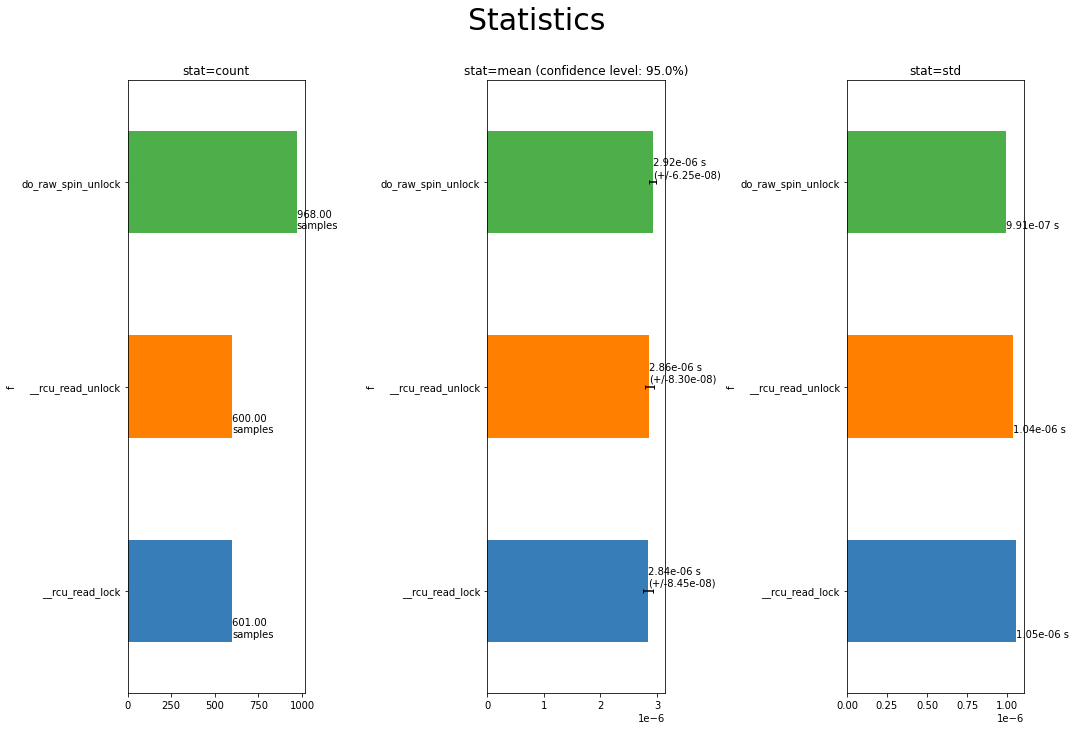

In [3]:
%matplotlib inline
# Use filename="..." to save to a file
fig = stats.plot_stats()

fig.set_figheight(10)
fig.set_figwidth(15)

### Compare profiling data from two traces

In [4]:
# "Create" two traces out of the first one by splitting it in half.
# In real life, it's likely you would have 2 different traces
half = trace.start + trace.time_range / 2
trace_ref = trace[:half]
trace_other = trace[half:]


stat_funcs = {'mean': None, 'count': None}

stats = trace_ref.analysis.functions.compare_with_traces(
    [trace_other],
    metric='self_time',
    functions=functions,
    stats=stat_funcs,
)
stats.df

,f,trace,stat,self_time,unit,ci_minus,ci_plus
0,__rcu_read_lock,1,count,-47.848101,%,NaN,NaN
1,__rcu_read_lock,1,mean,36.910807,%,NaN,NaN
2,__rcu_read_lock,1,ks2samp_test,0.000000,pval,NaN,NaN
3,__rcu_read_unlock,1,count,-48.101266,%,NaN,NaN
4,__rcu_read_unlock,1,mean,36.729223,%,NaN,NaN
5,__rcu_read_unlock,1,ks2samp_test,0.000000,pval,NaN,NaN
6,do_raw_spin_unlock,1,count,-19.739292,%,NaN,NaN
7,do_raw_spin_unlock,1,mean,27.189826,%,NaN,NaN
8,do_raw_spin_unlock,1,ks2samp_test,0.000000,pval,NaN,NaN


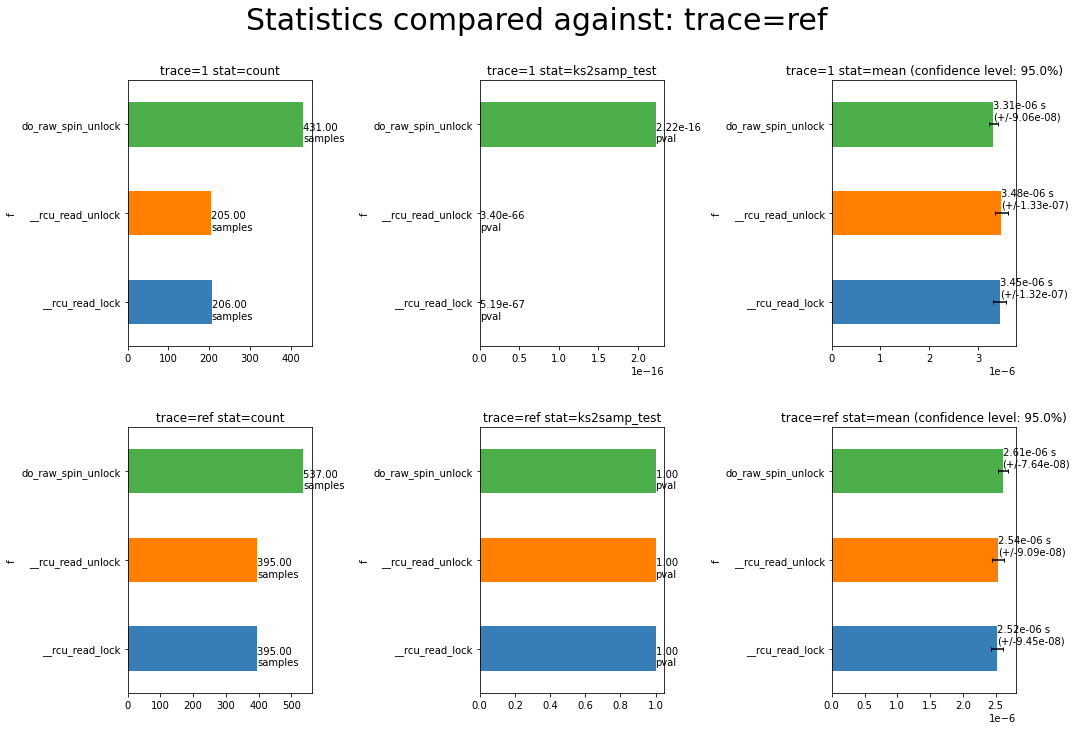

In [5]:
# Stats from both traces side by side
fig = stats.plot_stats(compare=False)
fig.set_figheight(10)
fig.set_figwidth(15)

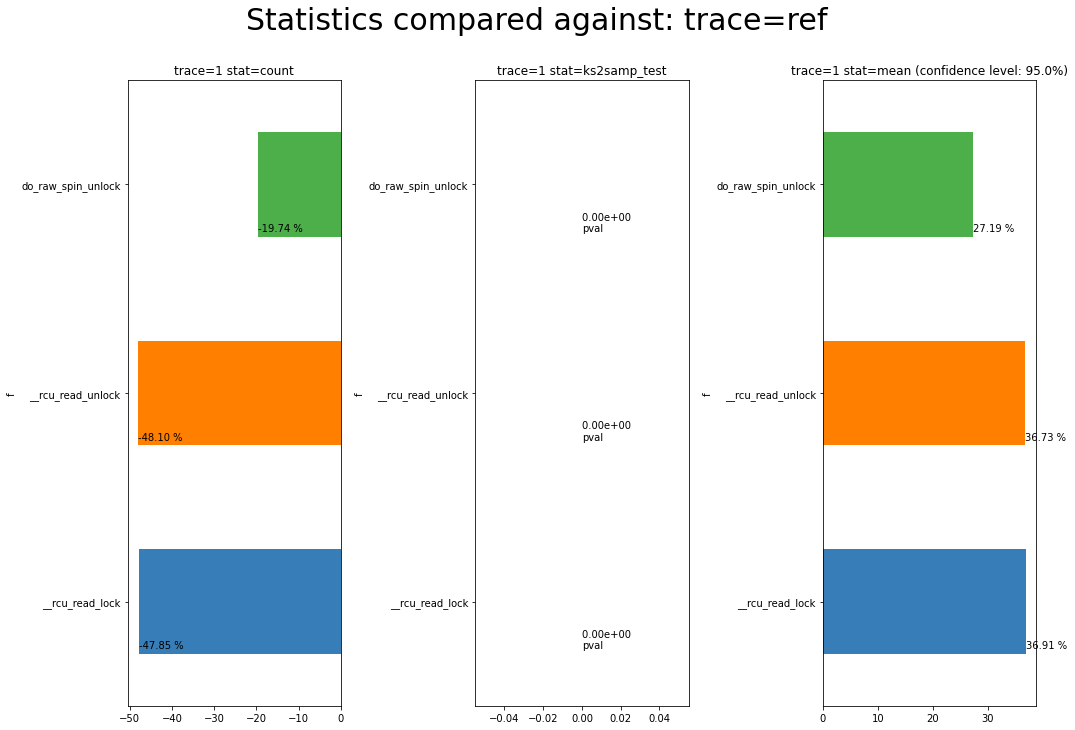

In [6]:
# Compare the information from the 2 traces
fig = stats.plot_stats(compare=True)
fig.set_figheight(10)
fig.set_figwidth(15)

## Using JSON profiling data

Note: this way of getting profiling information is deprecated in favor of direct use of ``funcgraph_exit`` and ``funcgraph_entry`` events present in the trace.

The profiling stats are JSON so let's load it up into a dict

In [14]:
import json

In [15]:
# Save the profiling stats
ftrace_coll.get_stats(os.path.join(wload.res_dir, "stats.json"))

stats_path = os.path.join(wload.res_dir, "stats.json")

with open(stats_path, "r") as fh:
    # That ';' is just there to prevent Jupyter from dumping the dict in stdout
    stats = json.load(fh);

The data in the file is arranged like so:

- For each CPU
    - For each function
       - time (µs)
       - hits (#)
       - s_2, AKA variance - apply sqrt() to get standard deviation
       - avg (µs)
       
To make it a bit simpler to manipulate, we're going to turn this data into a pandas DataFrame.

In [16]:
import pandas as pd

def stats_to_df(stats_dict):
    """
    Turn Ftrace function profiling stats into a pandas DataFtrame
    
    :param stats_dict: The stats dictionnary generated by FtraceCollector
    :type stats_dict: dict
    """
    data = []
    index = []
    
    for cpu, functions in stats_dict.items():
        index.append(int(cpu))
        columns = []
        line = []
        
        for function, stats in functions.items():
            
            for name, stat in stats.items():
                columns.append((function, name))
                line.append(stat)

        data.append(line)
        
    df = pd.DataFrame(data, index=index, columns=columns)
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=["function", "cpu"])
    df = df.sort_index()
    return df

In [17]:
df = stats_to_df(stats)

Here's how the Dataframe looks like:

In [18]:
df

function scheduler_tick                            run_rebalance_domains  \
cpu                hits     avg      time      s_2                  hits   
0                   129  14.732  1900.519   73.636                    49   
1                    68  17.210  1170.315  129.603                    36   
2                   226   6.395  1445.303   33.393                   136   
3                    32  10.807   345.836   10.798                    11   
4                   236   6.605  1558.855    9.492                    67   
5                   170   6.464  1098.950    9.395                    77   
6                   152   5.931   901.571    6.032                    62   
7                   177   6.776  1199.471   14.189                    72   

function                             
cpu          avg      time      s_2  
0         23.607  1156.778  461.905  
1         13.903   500.522   26.722  
2         14.326  1948.428   73.246  
3          6.534    71.875    3.545  
4          9.157   613.537   35.776  
5          9.699   746.874   61.791  
6          7.854   486.978   39.207  
7          9.505   684.375   45.281

We can easily have a look at a specific function:

In [19]:
df.run_rebalance_domains

cpu,hits,avg,time,s_2
0,49,23.607,1156.778,461.905
1,36,13.903,500.522,26.722
2,136,14.326,1948.428,73.246
3,11,6.534,71.875,3.545
4,67,9.157,613.537,35.776
5,77,9.699,746.874,61.791
6,62,7.854,486.978,39.207
7,72,9.505,684.375,45.281


It's also easy to get overall stats for one function. For instance, if we want the total number of hits for a function (summing up the number of hits over all CPUs), that can be done like so:

In [20]:
df.run_rebalance_domains.hits.sum()

510

You can also get stats recorded on a single CPU like so:

In [21]:
df.run_rebalance_domains.loc[2]

cpu
hits     136.000
avg       14.326
time    1948.428
s_2       73.246
Name: 2, dtype: float64

Now that we have all of the relevant data in Dataframe format, it's very easy to make plots out of it

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [23]:
def plot_hits(df, function):
    fig, ax = plt.subplots(figsize=(16, 5))
    
    df[function].hits.plot.bar(ax=ax)    
    ax.set_title("Per-CPU hits of \"{}\"".format(function))
    ax.set_xlabel("CPU")
    ax.set_ylabel("# of hits")
    ax.grid(True)

In [24]:
def plot_time_avg(df, function):
    fig, ax = plt.subplots(figsize=(16, 5))
    
    # Let's compute the standard deviation to plot error bars
    stddev = df[function].s_2.apply(np.sqrt)
    
    df[function].avg.plot.bar(ax=ax, yerr=stddev, capsize=10)    
    ax.set_title("Per-CPU average time of \"{}\"".format(function))
    ax.set_xlabel("CPU")
    ax.set_ylabel("Average time (µs)")
    ax.grid(True)

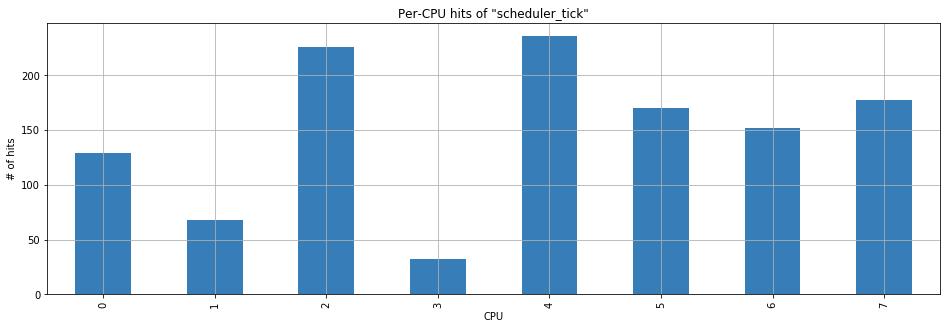

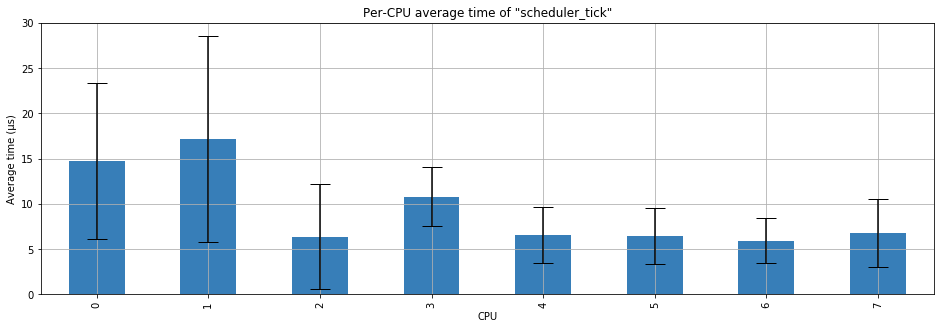

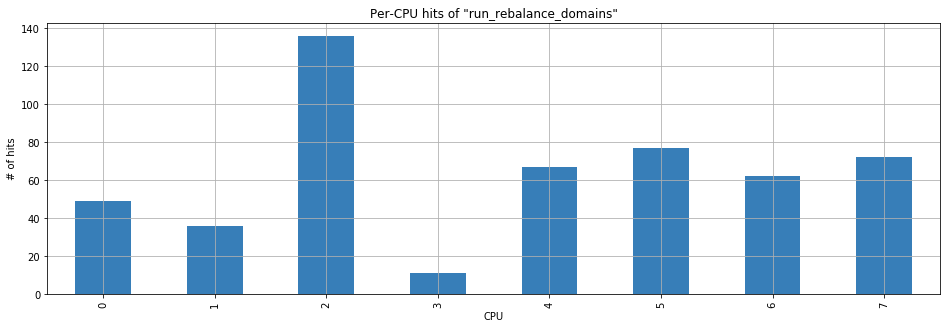

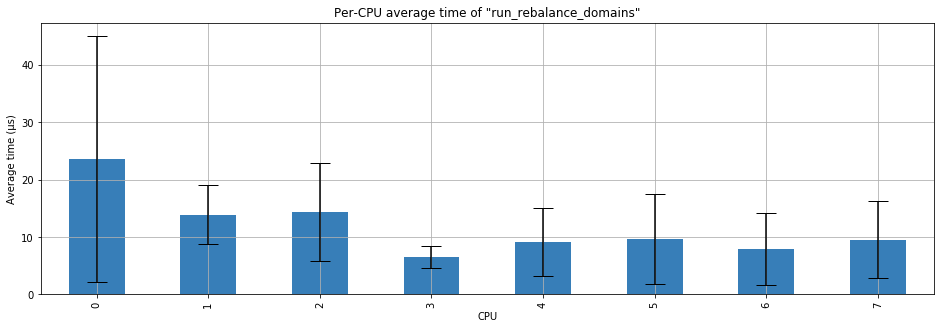

In [25]:
for function in functions:
    plot_hits(df, function)
    plot_time_avg(df, function)